In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import yaml, cv2, os
from torchvision.transforms import functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np

import time

import model_add as model
import model_concat as mconcat
import model_utility as ut
import matplotlib.pyplot as plt
import gc
from torch.utils.tensorboard import SummaryWriter

# Load dataset

In [2]:
# Load the datasets with ImageFolder

image_dir_8 = 'resolution_dataset/lr_f1_160_8'
label_dir = 'resolution_dataset/hr_f1_160'

dir_dictionary = ut.create_dictionary(image_dir_8,label_dir)

trans = transforms.Compose([
   transforms.CenterCrop(400),
])

In [3]:
image_datasets = ut.MRIDataset(image_dir_8,label_dir,dir_dict = dir_dictionary,test=False)

# Using the image datasets and the transforms, define the dataloaders
# dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=32, shuffle=True, num_workers=2)
dataloaders = DataLoader(image_datasets, batch_size=32, shuffle=True, num_workers=2)

# View Dataset

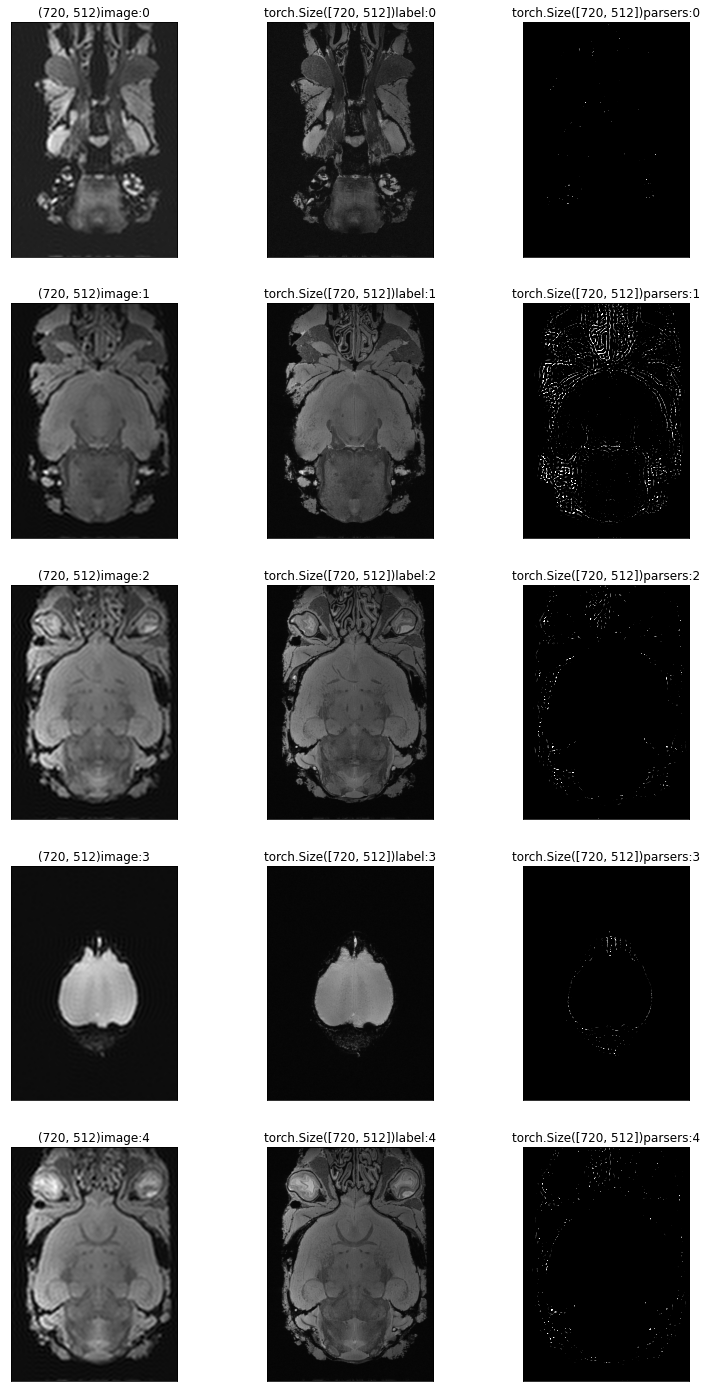

In [4]:
dataiter = iter(dataloaders)
images, labels, parsers = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(13,25))
k=0
for idx in np.arange(0,15,3):
    ax = fig.add_subplot(int(15/3), 3, idx+1, xticks=[], yticks=[])
    ut.imshow(images[k].squeeze(),'image:'+str(k))
    ax = fig.add_subplot( int(15/3),3, idx+2, xticks=[], yticks=[])
    ut.imshow(labels[k].squeeze(),'label:'+str(k))
    ax = fig.add_subplot(int(15/3),3, idx+3, xticks=[], yticks=[])
    ut.imshow(parsers[k].squeeze()*10 ,'parsers:'+str(k))
    k +=1

# Define loss function

In [5]:
loss_fn = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# hyperparameters
batch_size = 32
channels = 1
n_epochs = 3
learning_rate = 0.01

lbda = 0.3
alpha = 0.5
beta = 0.2

# Training a concatenation network

In [ ]:
model_concat = mconcat.MRINet(device)
model_concat = nn.DataParallel(model_concat,device_ids=[0,1])
model_concat.to(device)
# print(model_concat)

# tb = SummaryWriter()


# images, labels,parsers = next(iter(dataloaders))
# grid = torchvision.utils.make_grid(images)
# # grid_labels = torchvision.utils.make_grid(labels)
# # # grid_parsers= torchvision.utils.make_grid(parsers)
# tb.add_image("images", grid)
# tb.add_image("labels", grid_labels)
# tb.add_image("parsers", grid_parsers)
# tb.close()

# model_concat.eval()
# with torch.no_grad():
#     tb.add_graph(model_concat,images)

optim = torch.optim.SGD(params = model_concat.parameters(), lr = learning_rate, momentum=0.9)

model_concat.train() 
losses_concat = []
k = 0
for epoch in range(1, n_epochs + 1):
    for idx, (images, labels,parsers) in enumerate(dataloaders):
        images = images.to(device)
        labels = labels.to(device)
        parsers = parsers.to(device)
        torch.cuda.empty_cache()

        outputs,f,p,y_c = model_concat(images)

        loss_coarser = loss_fn(y_c, labels) 
        loss_decoder = loss_fn(outputs, labels) 
        loss_parser = loss_fn(p, parsers) 
        loss = (loss_coarser*beta) + (alpha * loss_decoder) + (loss_parser * lbda)

        optim.zero_grad()
        loss.backward()
        optim.step() 

        losses_concat.append(float(loss))
#         tb.add_scalar("Loss", float(loss), idx)
        
        if idx % 200 == 0:
            print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f" % (epoch, n_epochs, idx + 1, len(dataloaders), loss))
#     for name, weight in model_concat.named_parameters():
#         tb.add_histogram(name, weight, epoch)
#         tb.add_histogram(f'{name}.grad',weight.grad, epoch)
#     tb.add_scalar("Loss", float(loss), epoch)
    if k == 100:
        path = f'model/concat/model_concat_'+str(epoch)+'.pth'
        torch.save(model_concat.state_dict(), path)
        k=0
    k+=1
# tb.close()

In [ ]:
path = f'model/concat/model_concat'+'_final.pth'
torch.save(model_concat.state_dict(), path)

# Training a Addition Network

In [ ]:
model_add = model.MRINet(device)
model_add = nn.DataParallel(model_add,device_ids=[0,1])
model_add.to(device)
# print(model_add)

optim = torch.optim.SGD(params = model_add.parameters(), lr = learning_rate, momentum=0.9)


model_add.train() 
losses_add = []
k = 0
for epoch in range(1, n_epochs + 1):
    for idx, (images, labels,parsers) in enumerate(dataloaders):
        images = images.to(device)
        labels = labels.to(device)
        parsers = parsers.to(device)
        torch.cuda.empty_cache()

        outputs,f,p,y_c = model_add(images)

        loss_coarser = loss_fn(y_c, labels) 
        loss_decoder = loss_fn(outputs, labels) 
        loss_parser = loss_fn(p, parsers) 
        loss = (loss_coarser*beta) + (alpha * loss_decoder) + (loss_parser * lbda)

        optim.zero_grad()
        loss.backward()
        optim.step() 


        losses_add.append(float(loss))
        
        if idx % 200 == 0:
            print("Epoch [%d/%d]. Iter [%d/%d]. Loss: %0.2f" % (epoch, n_epochs, idx + 1, len(dataloaders), loss))
    if k == 100:
        path = f'model/add/model_add_'+str(epoch)+'.pth'
        torch.save(model_add.state_dict(), path)
        k=0
    k+=1

In [ ]:
path = f'model/add/model_add'+'_final.pth'
torch.save(model_add.state_dict(), path)

# Plot losses

In [ ]:
plt.figure()
plt.plot(losses_concat)
plt.title('loss plot for concatenation network')
plt.show()

In [ ]:
plt.figure()
plt.plot(losses_add)
plt.title('loss plot for additive network')
plt.show()